In [3]:
import pandas as pd
import numpy as np
import scipy

from pandas_datareader import data, wb

import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from pandas.tseries.offsets import *

In [4]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
#
# Real ticker data
#
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime.now()

#price_data = data.DataReader('AAPL', 'yahoo', start, end)
#adjclose_series = price_data['Adj Close']
#adjclose_series.name = 'close'

#df = pd.DataFrame(adjclose_series)
#
#

strategyname = 'strategy_470240'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

df = pd.DataFrame()
df['close'] = d.exo / 100

box_size = 1

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

column_flag = None

reversal_value = box_size * 3

reversal_flag = False

column_index = 0

# Simple point and figure algorihtm

for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start

        # First of all we need to set box size.
        # Then calculate price movement.
        # If price movement is more or equal than box size - renko bar(or bars) will be added

        if np.abs(price_move) >= box_size:

            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much pnf boxes will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_date = df.close.index[i]

            if column_flag == 'x' and reversal_flag == False:

                # Reversal check
                if price_move < 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    

                elif price_move > 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            if column_flag == 'o' and reversal_flag == False:

                # Reversal check
                if price_move > 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    

                elif price_move < 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):
                        d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                             'type': column_flag, 'column_index': column_index}

                        box_end = d['close']
                        temp_l.append(d)

            if column_flag == None and reversal_flag == False:

                # Adding first column

                if price_move > 0:
                    column_flag = 'x'

                if price_move < 0:
                    column_flag = 'o'

                for b in range(int(box_quantity)):
                    if column_flag == 'x':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                    if column_flag == 'o':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            # Handling the reversals
            if reversal_flag == True:
                column_index += 1
                
                if column_flag == 'x':

                    column_flag = 'o'

                    for b in range(int(box_quantity)):
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                elif column_flag == 'o':

                    column_flag = 'x'

                    for b in range(int(box_quantity)):
                        d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                             'type': column_flag, 'column_index': column_index}

                        box_end = d['close']
                        temp_l.append(d)

                reversal_flag = False
        try:
            box_start = temp_l[-1]['close']
            
        except IndexError:
            box_start = df.close[i]
            
pnf_df = pd.DataFrame(temp_l)                
pnf_df.index = pnf_df.column_index

pnf_last_column_value_df = pnf_df.groupby(pnf_df.index).last()
pnf_first_column_value_df = pnf_df.groupby(pnf_df.index).first()

# Patterns

In [234]:
# New x column

pnf_prev1_df = pnf_df.shift(1)

#pnf_prev1_last_column_value_df = pnf_df.shift(1).groupby(pnf_df.index).last()

pnf_df['new_x_col'] = (pnf_df.type == 'x') & (pnf_df.type.shift(1) == 'o')
pnf_df['new_o_col'] = (pnf_df.type == 'o') & (pnf_df.type.shift(1) == 'x')

In [235]:
pnf_df['tripple_top'] = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close == \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)

pnf_df['tripple_top'] = pnf_df['tripple_top'].fillna(False)

pnf_df['tripple_top_price_level'] = pnf_df[pnf_df.tripple_top == True].groupby(pnf_df[pnf_df.tripple_top == True].index).last().close
pnf_df['tripple_top_price_level'] = pnf_df['tripple_top_price_level'].ffill()

pnf_df['tripple_top_breakout'] =((pnf_df.close == pnf_df.tripple_top_price_level) & (pnf_df.close.shift(1) < pnf_df.tripple_top_price_level) 
                                & (pnf_df.tripple_top==False))

In [236]:
pnf_df['tripple_bot'] = pnf_last_column_value_df[pnf_last_column_value_df.type == 'o'].close == \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'o'].close.shift(1)
    
pnf_df['tripple_bot'] = pnf_df['tripple_bot'].fillna(False)

pnf_df['tripple_bot_price_level'] = pnf_df[pnf_df.tripple_bot == True].groupby(pnf_df[pnf_df.tripple_bot == True].index).last().close
pnf_df['tripple_bot_price_level'] = pnf_df['tripple_bot_price_level'].ffill()

pnf_df['tripple_bot_breakout'] =((pnf_df.close == pnf_df.tripple_bot_price_level) & (pnf_df.close.shift(1) > pnf_df.tripple_bot_price_level) 
                                & (pnf_df.tripple_bot==False))

## Removing a duplicated breakouts
### Optional, because these breakouts can be treated as support/resistance levels breakouts

In [237]:
tripple_top_breakout_dup = pnf_df[pnf_df.tripple_top_breakout == True]['tripple_top_price_level'].duplicated() 

pnf_df.loc[tripple_top_breakout_dup[tripple_top_breakout_dup == True].index, 'tripple_top_breakout'] = pnf_df.tripple_top_breakout.ix[
    tripple_top_breakout_dup[tripple_top_breakout_dup == True].index].replace(True,False)

tripple_bot_breakout_dup = pnf_df[pnf_df.tripple_top_breakout == True]['tripple_top_price_level'].duplicated() 

pnf_df.loc[tripple_bot_breakout_dup[tripple_bot_breakout_dup == True].index, 'tripple_bot_breakout'] = pnf_df.tripple_bot_breakout.ix[
    tripple_bot_breakout_dup[tripple_bot_breakout_dup == True].index].replace(True,False)

In [238]:
up_move_count = [0]
up_move_counter = 0

down_move_count = [0]
down_move_counter = 0

same_move_count = [0]
same_move_counter = 0

x_col_upmove = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close > \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)
    
x_col_downmove = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close < \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)
    
x_col_samemove = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close < \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)
    
for i in x_col_upmove.index:
    if x_col_upmove[i] == True and x_col_upmove.shift(1)[i] == False:
        up_move_counter = 1
        up_move_count.append(up_move_counter)
        
    elif x_col_upmove[i] == True and x_col_upmove.shift(1)[i] == True:
        up_move_counter += 1
        up_move_count.append(up_move_counter)
        
    elif x_col_upmove[i] == False and x_col_upmove.shift(1)[i] == True:
        up_move_counter = 0
        up_move_count.append(up_move_counter)
        
    elif x_col_upmove[i] == False and x_col_upmove.shift(1)[i] == False:
        up_move_counter = 0
        up_move_count.append(up_move_counter)
      
    
    
    if x_col_downmove[i] == True and x_col_downmove.shift(1)[i] == False:
        down_move_counter = 1
        down_move_count.append(down_move_counter)
        
    elif x_col_downmove[i] == True and x_col_downmove.shift(1)[i] == True:
        down_move_counter += 1
        down_move_count.append(down_move_counter)
        
    elif x_col_downmove[i] == False and x_col_downmove.shift(1)[i] == True:
        down_move_counter = 0
        down_move_count.append(down_move_counter)
        
    elif x_col_downmove[i] == False and x_col_downmove.shift(1)[i] == False:
        down_move_counter = 0
        down_move_count.append(down_move_counter)  
      
    
    
    if x_col_samemove[i] == True and x_col_samemove.shift(1)[i] == False:
        same_move_counter = 1
        same_move_count.append(same_move_counter)
        
    elif x_col_samemove[i] == True and x_col_samemove.shift(1)[i] == True:
        same_move_counter += 1
        same_move_count.append(same_move_counter)
        
    elif x_col_samemove[i] == False and x_col_samemove.shift(1)[i] == True:
        same_move_counter = 0
        same_move_count.append(same_move_counter)
        
    elif x_col_samemove[i] == False and x_col_samemove.shift(1)[i] == False:
        same_move_counter = 0
        same_move_count.append(same_move_counter)
        
pnf_df['x_col_upmove_count'] = pd.Series(up_move_count, index=x_col_upmove.index)
pnf_df['x_col_downmove_count'] = pd.Series(down_move_count, index=x_col_upmove.index)
pnf_df['x_col_samemove_count'] = pd.Series(same_move_count, index=x_col_upmove.index)

In [239]:
up_move_count = [0]
up_move_counter = 0

down_move_count = [0]
down_move_counter = 0

same_move_count = [0]
same_move_counter = 0

o_col_upmove = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close > \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)
    
o_col_downmove = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close < \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)
    
o_col_samemove = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close < \
                            pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)
    
for i in o_col_upmove.index:
    if o_col_upmove[i] == True and o_col_upmove.shift(1)[i] == False:
        up_move_counter = 1
        up_move_count.append(up_move_counter)
        
    elif o_col_upmove[i] == True and o_col_upmove.shift(1)[i] == True:
        up_move_counter += 1
        up_move_count.append(up_move_counter)
        
    elif o_col_upmove[i] == False and o_col_upmove.shift(1)[i] == True:
        up_move_counter = 0
        up_move_count.append(up_move_counter)
        
    elif o_col_upmove[i] == False and o_col_upmove.shift(1)[i] == False:
        up_move_counter = 0
        up_move_count.append(up_move_counter)
      
    
    
    if o_col_downmove[i] == True and o_col_downmove.shift(1)[i] == False:
        down_move_counter = 1
        down_move_count.append(down_move_counter)
        
    elif o_col_downmove[i] == True and o_col_downmove.shift(1)[i] == True:
        down_move_counter += 1
        down_move_count.append(down_move_counter)
        
    elif o_col_downmove[i] == False and o_col_downmove.shift(1)[i] == True:
        down_move_counter = 0
        down_move_count.append(down_move_counter)
        
    elif o_col_downmove[i] == False and o_col_downmove.shift(1)[i] == False:
        down_move_counter = 0
        down_move_count.append(down_move_counter)  
      
    
    
    if o_col_samemove[i] == True and o_col_samemove.shift(1)[i] == False:
        same_move_counter = 1
        same_move_count.append(same_move_counter)
        
    elif o_col_samemove[i] == True and o_col_samemove.shift(1)[i] == True:
        same_move_counter += 1
        same_move_count.append(same_move_counter)
        
    elif o_col_samemove[i] == False and o_col_samemove.shift(1)[i] == True:
        same_move_counter = 0
        same_move_count.append(same_move_counter)
        
    elif o_col_samemove[i] == False and o_col_samemove.shift(1)[i] == False:
        same_move_counter = 0
        same_move_count.append(same_move_counter)
        
pnf_df['o_col_upmove_count'] = pd.Series(up_move_count, index=o_col_upmove.index)
pnf_df['o_col_downmove_count'] = pd.Series(down_move_count, index=o_col_upmove.index)
pnf_df['o_col_samemove_count'] = pd.Series(same_move_count, index=o_col_upmove.index)

## Projection count

In [240]:
pnf_last_column_value_df[pnf_last_column_value_df.close == \
                          pnf_last_column_value_df.close.expanding(min_periods=20).min()]

#pnf_df.ix[37].close.count() # 4

#pnf_last_column_value_df.ix[36].close # 17.43

pnf_df['px_low'] = pnf_last_column_value_df.close == pnf_last_column_value_df.close.expanding(min_periods=20).min()

pnf_df['px_low_lastprice'] = pnf_last_column_value_df[pnf_last_column_value_df.close == 
                                                      pnf_last_column_value_df.close.expanding(min_periods=20).min()].close

pnf_df['px_low_lastprice'] = pnf_df['px_low_lastprice'].ffill()

pnf_df['px_low_boxcount'] = np.zeros_like(pnf_df.index)



for i in pnf_df[(pnf_df.px_low == False) & (pnf_df.px_low.shift(1) == True)].index:
    pnf_df.loc[i,'px_low_boxcount'] = pnf_df.ix[i].close.count()

pnf_df['px_low_entry'] = (pnf_df.px_low_boxcount.shift(1) != 0) & (pnf_df.px_low_boxcount == 0) & (pnf_df.px_low != True)


for i in pnf_df[(pnf_df.px_low_boxcount != 0)].index:
    pnf_df.loc[i,'px_low_hightarget'] = (box_size * reversal_value * pnf_df.px_low_boxcount.ix[i]) + pnf_df.px_low_lastprice.ix[i] 
    
pnf_df['px_low_hightarget'] = pnf_df['px_low_hightarget'].ffill()

In [241]:
pnf_df['px_low_hightarget']

column_index
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
0            NaN
         ...    
375   -1687.8125
375   -1687.8125
375   -1687.8125
375   -1687.8125
375   -1687.8125
375   -1687.8125
375   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
376   -1687.8125
3

In [242]:
(box_size * reversal_value * pnf_df.ix[i].px_low_boxcount) + pnf_df.px_low_lastprice.ix[i]

column_index
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
190   -1687.8125
dtype: float64

In [243]:
pnf_df.ix[169]

,close,column_index,date,open,type,new_x_col,new_o_col,tripple_top,tripple_top_price_level,tripple_top_breakout,...,x_col_downmove_count,x_col_samemove_count,o_col_upmove_count,o_col_downmove_count,o_col_samemove_count,px_low,px_low_lastprice,px_low_boxcount,px_low_entry,px_low_hightarget
column_index,,,,,,,,,,,,,,,,,,,,,
169,-1770.8125,169,2014-01-06,-1769.8125,o,False,True,False,-1736.8125,False,...,NaN,NaN,NaN,NaN,NaN,False,-1793.8125,0,True,-1721.8125
169,-1771.8125,169,2014-01-06,-1770.8125,o,False,False,False,-1736.8125,False,...,NaN,NaN,NaN,NaN,NaN,False,-1793.8125,0,False,-1721.8125
169,-1772.8125,169,2014-01-06,-1771.8125,o,False,False,False,-1736.8125,False,...,NaN,NaN,NaN,NaN,NaN,False,-1793.8125,0,False,-1721.8125
169,-1773.8125,169,2014-01-06,-1772.8125,o,False,False,False,-1736.8125,False,...,NaN,NaN,NaN,NaN,NaN,False,-1793.8125,0,False,-1721.8125
169,-1774.8125,169,2014-01-06,-1773.8125,o,False,False,False,-1736.8125,False,...,NaN,NaN,NaN,NaN,NaN,False,-1793.8125,0,False,-1721.8125
169,-1775.8125,169,2014-01-06,-1774.8125,o,False,False,False,-1736.8125,False,...,NaN,NaN,NaN,NaN,NaN,False,-1793.8125,0,False,-1721.8125
169,-1776.8125,169,2014-01-06,-1775.8125,o,False,False,False,-1736.8125,False,...,NaN,NaN,NaN,NaN,NaN,False,-1793.8125,0,False,-1721.8125


In [244]:
(box_size * reversal_value * 16) + -274.56

-226.56

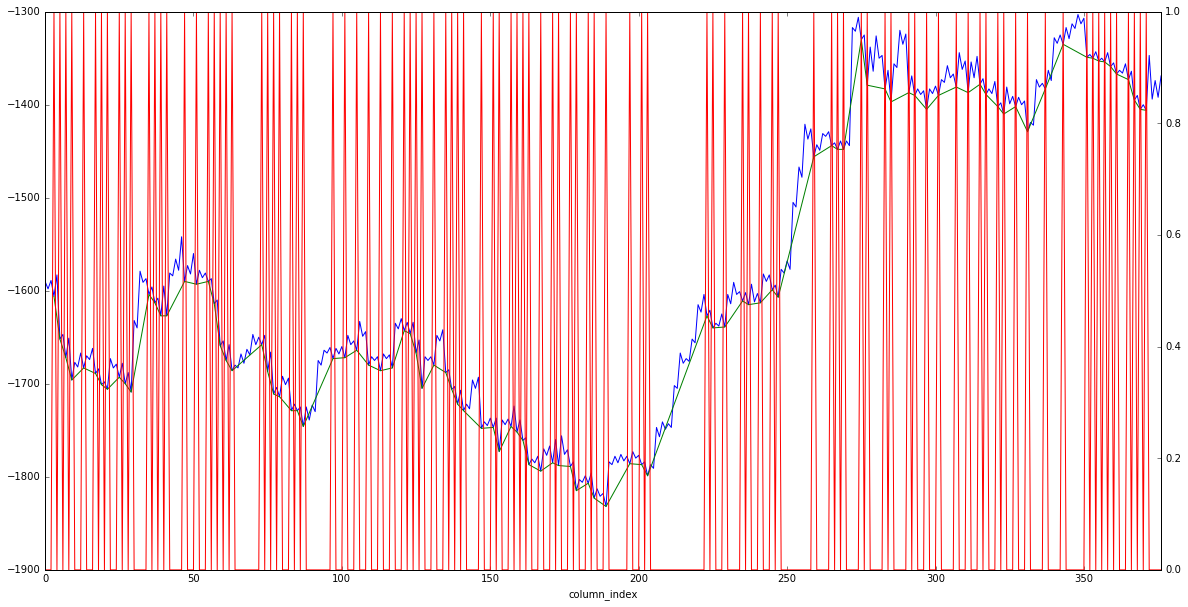

In [281]:
pnf_last_column_value_df.close.plot()

pnf_last_column_value_df[(pnf_last_column_value_df.close == pnf_last_column_value_df.close.rolling(len(pnf_last_column_value_df.close) * 0.01).min()) == True].close.plot()

((pnf_last_column_value_df.close == pnf_last_column_value_df.close.rolling(len(pnf_last_column_value_df.close) * 0.01).min()) == True).plot(secondary_y=True)


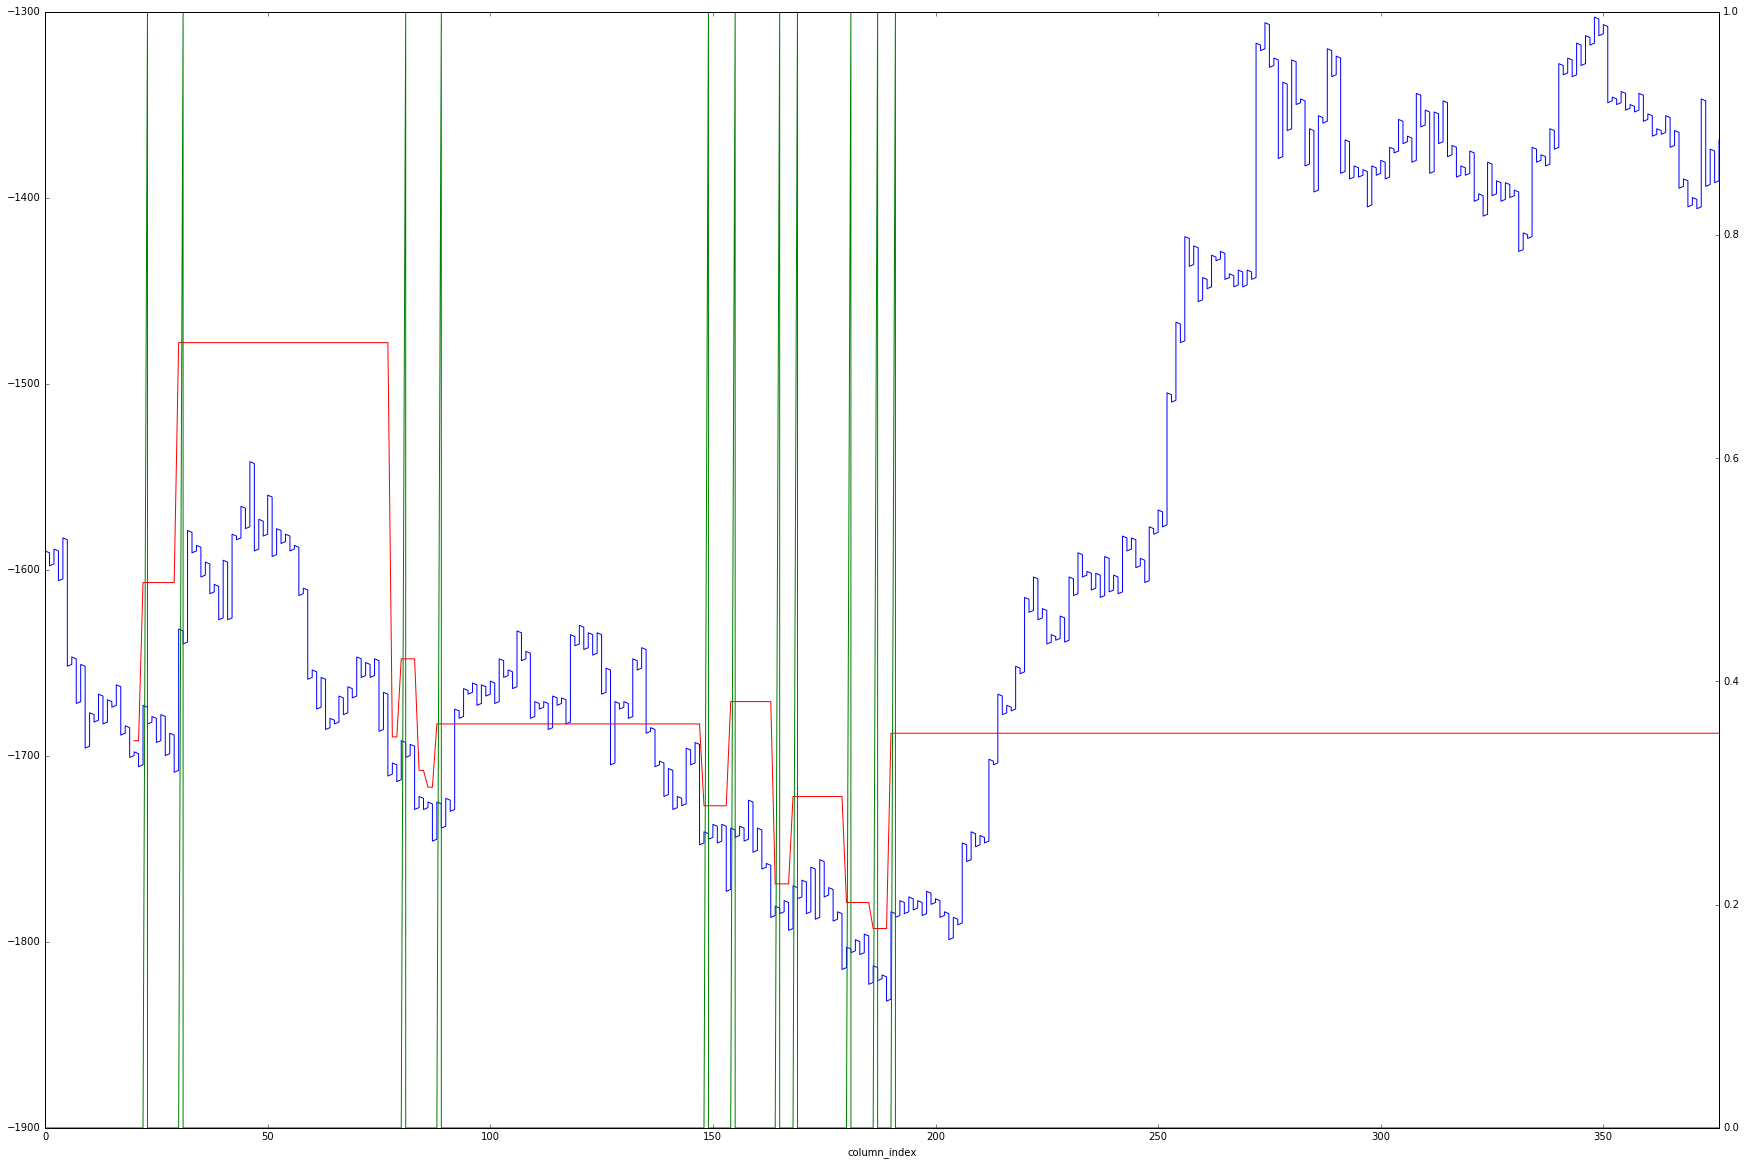

In [252]:
pnf_df.close.plot()
pnf_df.px_low_entry.plot(secondary_y=True)
pnf_df.px_low_hightarget.dropna().plot()

In [174]:
pnf_df[(pnf_df.px_low_boxcount != 0)]

,close,column_index,date,open,type,new_x_col,new_o_col,tripple_top,tripple_top_price_level,tripple_top_breakout,...,x_col_upmove_count,x_col_downmove_count,x_col_samemove_count,o_col_upmove_count,o_col_downmove_count,o_col_samemove_count,px_low,px_low_boxcount,px_low_lastprice,px_low_entry
column_index,,,,,,,,,,,,,,,,,,,,,
37,-36.5625,37,2012-11-08,-37.5625,x,True,False,False,3.4375,False,...,0.0,3.0,3.0,0.0,3.0,3.0,False,4,-37.5625,False
37,-35.5625,37,2012-11-08,-36.5625,x,False,False,False,3.4375,False,...,0.0,3.0,3.0,0.0,3.0,3.0,False,4,-37.5625,False
37,-34.5625,37,2012-11-08,-35.5625,x,False,False,False,3.4375,False,...,0.0,3.0,3.0,0.0,3.0,3.0,False,4,-37.5625,False
37,-33.5625,37,2012-11-08,-34.5625,x,False,False,False,3.4375,False,...,0.0,3.0,3.0,0.0,3.0,3.0,False,4,-37.5625,False
39,-73.5625,39,2013-01-07,-74.5625,x,True,False,False,3.4375,False,...,0.0,4.0,4.0,0.0,4.0,4.0,False,7,-74.5625,False
39,-72.5625,39,2013-01-07,-73.5625,x,False,False,False,3.4375,False,...,0.0,4.0,4.0,0.0,4.0,4.0,False,7,-74.5625,False
39,-71.5625,39,2013-01-07,-72.5625,x,False,False,False,3.4375,False,...,0.0,4.0,4.0,0.0,4.0,4.0,False,7,-74.5625,False
39,-70.5625,39,2013-01-08,-71.5625,x,False,False,False,3.4375,False,...,0.0,4.0,4.0,0.0,4.0,4.0,False,7,-74.5625,False
39,-69.5625,39,2013-01-08,-70.5625,x,False,False,False,3.4375,False,...,0.0,4.0,4.0,0.0,4.0,4.0,False,7,-74.5625,False


In [149]:
pnf_df['px_low_lastprice'].dropna()

column_index
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
36     -37.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
38     -74.5625
         ...   
154   -270.5625
154   -270.5625
154   -270.5625
154   -270.5625
154   -270.5625
154   -270.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
166   -272.5625
168   -274.5625
168   -274.5625
168   -274.5625
168   -274.5625
168   -274.5625
Name: px_lo

In [188]:
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

ddd = d.join(pnf_df.set_index('date')[['new_x_col', 'new_o_col', 'tripple_bot_breakout', 'tripple_top_breakout']])
ddd.new_o_col == True

2012-01-03    False
2012-01-04    False
2012-01-05    False
2012-01-06    False
2012-01-09    False
2012-01-10    False
2012-01-11    False
2012-01-12    False
2012-01-13    False
2012-01-16    False
2012-01-17    False
2012-01-18    False
2012-01-19    False
2012-01-20    False
2012-01-23    False
2012-01-24    False
2012-01-25    False
2012-01-26    False
2012-01-27    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-30    False
2012-01-31    False
2012-02-01    False
2012-02-02    False
2012-02-03    False
              ...  
2016-03-16    False
2016-03-17    False
2016-03-18    False
2016-03-21    False
2016-03-21    False
2016-03-22    False
2016-03-23    False
2016-03-24    False
2016-03-25    False
2016-03-28    False
2016-03-29    False
2016-03-30    False
2016-03-31    False
2016-04-01    False
2016-04-04    False
2016-04-05    False
2016-04-06    False
2016-04-07    False
2016-04-08    False


In [5]:
var = pnf_df[(pnf_df.close == pnf_df.close.rolling(len(pnf_df.close) * 0.01).min()) == True]
#var.index.unique()

#var = pnf_df[(pnf_df.close == pnf_df.close.expanding().max()) == True]

for i in var.index.unique():
    
    if i > 0:
                  
        pnf_df['test_trendline_'+str(i)] = np.array([np.NaN] * len(pnf_df.index))
        pnf_df.loc[i-1, 'test_trendline_'+str(i)] = pnf_df.close[i-1]

        pnf_df.loc[i, 'test_trendline_'+str(i)] = pnf_first_column_value_df.close[i]

        pnf_df['test_trendline_'+str(i)] = pnf_df['test_trendline_'+str(i)].groupby(
            pnf_df['test_trendline_'+str(i)].index).last().interpolate('barycentric')

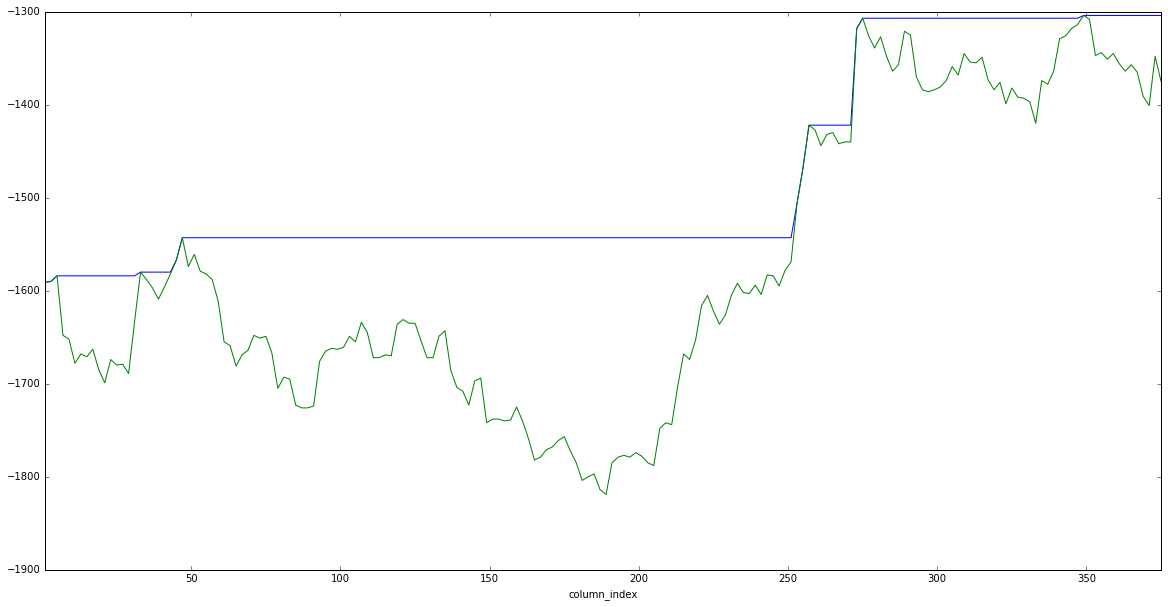

In [253]:
figsize(20,10)

pnf_first_column_value_df[pnf_first_column_value_df.type == 'o'].close.expanding().max().plot(legend=False)

pnf_first_column_value_df[pnf_first_column_value_df.type == 'o'].close.plot(legend=False)

In [12]:
pnf_df[(pnf_df.date > '2015-12-31') & (pnf_df.date < '2016-12-31')]

,close,column_index,date,open,type,new_x_col,new_o_col,tripple_top,tripple_top_price_level,tripple_top_breakout,tripple_bot,tripple_bot_price_level,tripple_bot_breakout,x_col_upmove_count,x_col_downmove_count,x_col_samemove_count,o_col_upmove_count,o_col_downmove_count,o_col_samemove_count
column_index,,,,,,,,,,,,,,,,,,,
173,-255.5625,173,2016-01-04,-256.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0
173,-254.5625,173,2016-01-04,-255.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0
173,-253.5625,173,2016-01-04,-254.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0
173,-252.5625,173,2016-01-04,-253.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0
173,-251.5625,173,2016-01-04,-252.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0
173,-250.5625,173,2016-01-04,-251.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0
173,-249.5625,173,2016-01-04,-250.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0
173,-248.5625,173,2016-01-05,-249.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0
173,-247.5625,173,2016-01-05,-248.5625,x,False,False,False,-242.5625,False,False,-264.5625,False,3.0,0.0,0.0,3.0,0.0,0.0


In [13]:
close_prices_occurance = pnf_last_column_value_df.close.groupby(pnf_last_column_value_df.close).count()
close_prices_occurance[close_prices_occurance >= 4]

close
-230.5625    4
-163.5625    4
-146.5625    4
dtype: int64

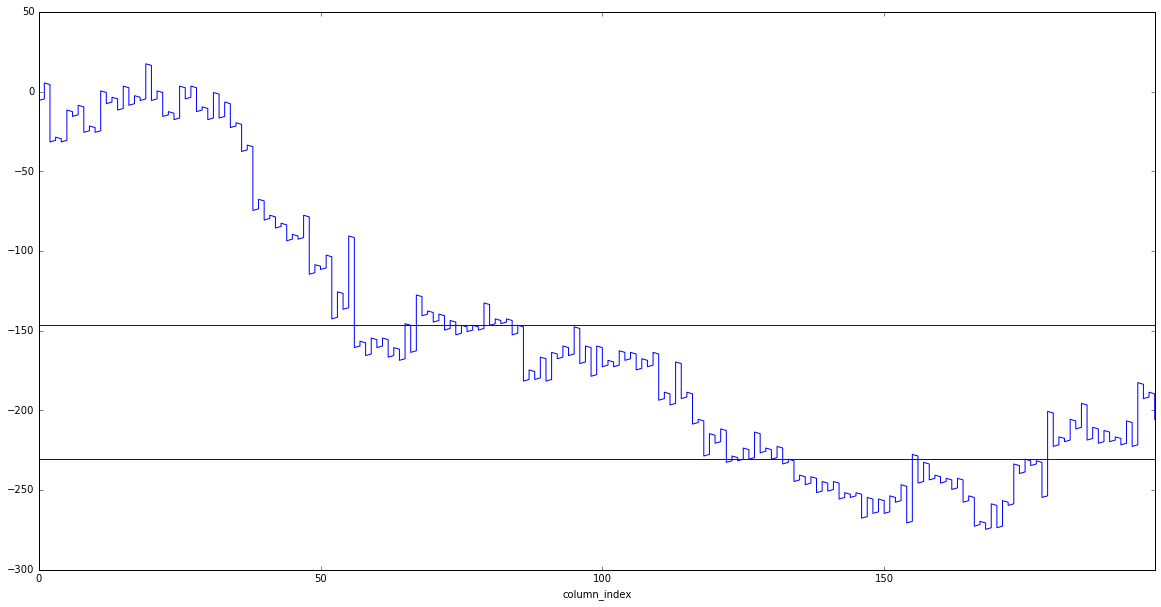

In [16]:
pnf_df.close.plot()

axhline(-230.5625)
axhline(-146.5625)
#axhline(207.434017)
#axhline(-4920.0)

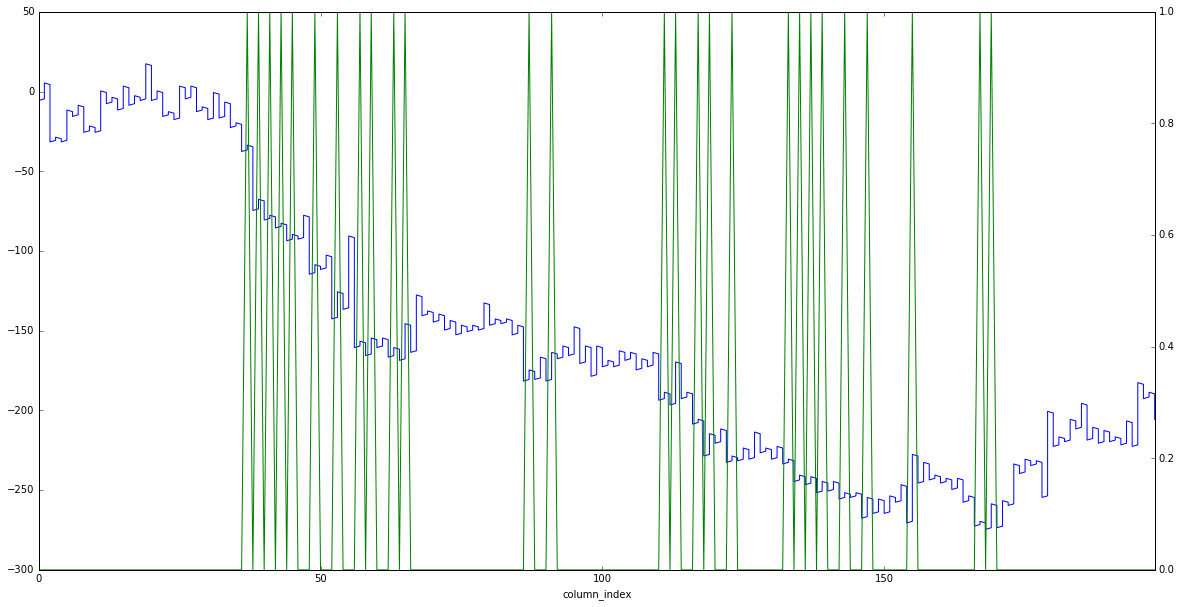

In [91]:
pnf_df.close.plot()
#(pnf_df.close.rolling(len(pnf_df.close) * 0.05).min()).plot(secondary_y=True)
#pnf_df[(pnf_df.date > '2014-12-31') & (pnf_df.date < '2015-12-31')].close.expanding(min_periods=10).max().plot()
#(pnf_df.close == pnf_df[(pnf_df.date > '2014-12-31') & (pnf_df.date < '2015-12-31')].close.max()).plot(secondary_y=True)
#(pnf_first_column_value_df.close.expanding(min_periods=10).min()).plot()
pnf_df['px_low'].plot(secondary_y=True)

In [17]:
pnf_df[pnf_df.close == pnf_df.close.min()]

,close,column_index,date,open,type,new_x_col,new_o_col,tripple_top,tripple_top_price_level,tripple_top_breakout,tripple_bot,tripple_bot_price_level,tripple_bot_breakout,x_col_upmove_count,x_col_downmove_count,x_col_samemove_count,o_col_upmove_count,o_col_downmove_count,o_col_samemove_count
column_index,,,,,,,,,,,,,,,,,,,
168,-274.5625,168,2015-12-07,-273.5625,o,False,False,False,-242.5625,False,False,-264.5625,False,NaN,NaN,NaN,NaN,NaN,NaN


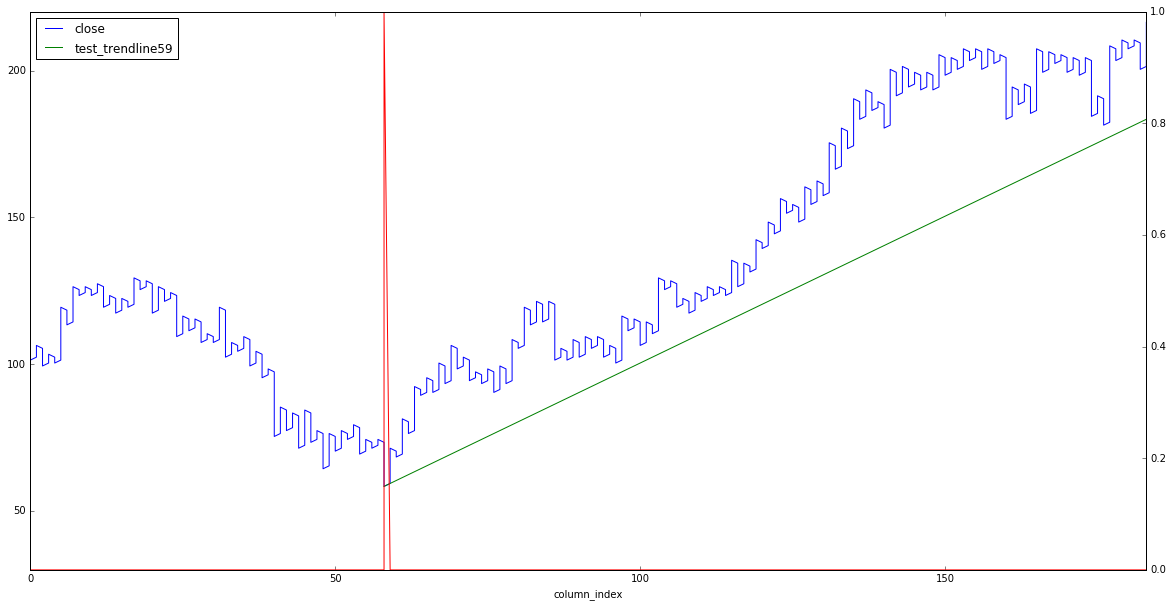

In [44]:
i=59

pnf_df['test_trendline'+str(i)] = np.array([np.NaN] * len(pnf_df.index))
pnf_df.loc[i-1, 'test_trendline'+str(i)] = pnf_df.close[i-1]
pnf_df.loc[i, 'test_trendline'+str(i)] = pnf_first_column_value_df.close[i]

pnf_df['test_trendline'+str(i)] = pnf_df['test_trendline'+str(i)].groupby(
    pnf_df['test_trendline'+str(i)].index).last().interpolate('barycentric')

pnf_df.drop(['open', 'column_index'],1).plot(ylim=[30,220])
#(pnf_df.close == pnf_df.close.rolling(len(pnf_df.close) * 0.05).max()).plot(secondary_y=True)7
#(pnf_df.close == pnf_df.close.min()).plot(secondary_y=True)
(pnf_df.close == pnf_df.close.min()).plot(secondary_y=True)

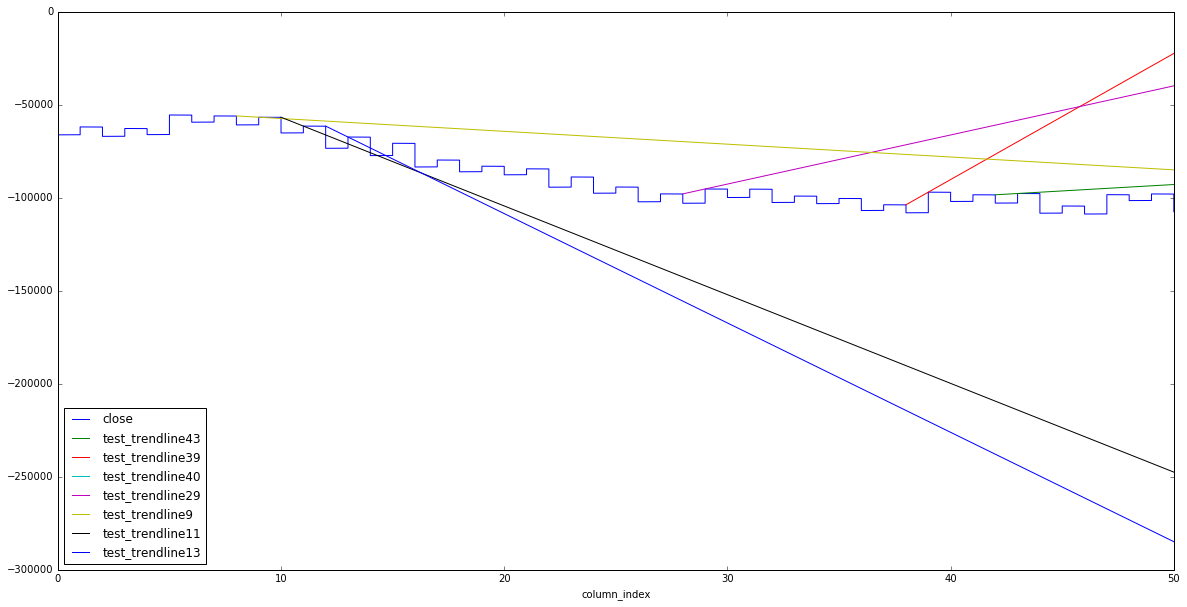

In [153]:
i=13

pnf_df['test_trendline'+str(i)] = np.array([np.NaN] * len(pnf_df.index))
pnf_df.loc[i-1, 'test_trendline'+str(i)] = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close.shift(1)[i]
pnf_df.loc[i, 'test_trendline'+str(i)] = pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close[i]

pnf_df['test_trendline'+str(i)] = pnf_df['test_trendline'+str(i)].groupby(
    pnf_df['test_trendline'+str(i)].index).last().interpolate('barycentric')

#pnf_df['test_trendline'+str(i)] = pnf_df['test_trendline'+str(i)].interpolate('barycentric')

#pnf_df['test_trendline'+str(i)].groupby(pnf_df['test_trendline'+str(i)].index).last().dropna()
pnf_df.drop(['open', 'column_index'],1).plot()

In [144]:
pnf_df.ix[39]

,close,column_index,date,open,type,test_trendline43
column_index,,,,,,
39,-107987.5,39,2015-08-20,-108017.5,x,NaN
39,-107957.5,39,2015-08-20,-107987.5,x,NaN
39,-107927.5,39,2015-08-20,-107957.5,x,NaN
39,-107897.5,39,2015-08-20,-107927.5,x,NaN
39,-107867.5,39,2015-08-20,-107897.5,x,NaN
39,-107837.5,39,2015-08-20,-107867.5,x,NaN
39,-107807.5,39,2015-08-20,-107837.5,x,NaN
39,-107777.5,39,2015-08-20,-107807.5,x,NaN
39,-107747.5,39,2015-08-20,-107777.5,x,NaN


In [132]:
pnf_df.ix[41]

,close,column_index,date,open,type,test_trendline24,test_trendline41
column_index,,,,,,,
41,76.434017,41,2008-10-13,75.434017,x,NaN,85.434017
41,77.434017,41,2008-10-13,76.434017,x,NaN,85.434017
41,78.434017,41,2008-10-13,77.434017,x,NaN,85.434017
41,79.434017,41,2008-10-13,78.434017,x,NaN,85.434017
41,80.434017,41,2008-10-13,79.434017,x,NaN,85.434017
41,81.434017,41,2008-10-13,80.434017,x,NaN,85.434017
41,82.434017,41,2008-10-13,81.434017,x,NaN,85.434017
41,83.434017,41,2008-10-13,82.434017,x,NaN,85.434017
41,84.434017,41,2008-10-13,83.434017,x,NaN,85.434017


In [147]:
pnf_last_column_value_df[pnf_last_column_value_df.type == 'x'].close

column_index
1     -61847.5
3     -62687.5
5     -55427.5
7     -55937.5
9     -56627.5
11    -61397.5
13    -67277.5
15    -70637.5
17    -79637.5
19    -82967.5
21    -84377.5
23    -88757.5
25    -94157.5
27    -97847.5
29    -95207.5
31    -95297.5
33    -99017.5
35   -100307.5
37   -103697.5
39    -96917.5
41    -98327.5
43    -97637.5
45   -104357.5
47    -98267.5
49    -97877.5
Name: close, dtype: float64

In [31]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

py.sign_in('tmqr', '8rctfyu197')


trace1 = go.Scatter(
    x = pnf_df[pnf_df.type == 'o'].index,
    y = pnf_df[pnf_df.type == 'o'].close,
    name='Down',
    mode = 'markers',
    marker = dict(symbol="o", size=5, color = 'rgba(255, 0, 0, 0.9)'),
    text = pnf_df[pnf_df.type == 'o'].date
)

trace2 = go.Scatter(
    x = pnf_df[pnf_df.type == 'x'].index,
    y = pnf_df[pnf_df.type == 'x'].close,
    name = 'Up',
    mode = 'markers',
    marker = dict(symbol="x", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    text = pnf_df[pnf_df.type == 'x'].date
    ) 

xo = [trace1, trace2]

layout = go.Layout(
    title="Point And Figure",
    xaxis=dict( autotick=True, autorange=True
        )
    )
fig = go.Figure(data=xo, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')

In [8]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')

In [16]:
pnf_df.ix[27]

,close,column_index,date,open,type
column_index,,,,,
27,70.896242,27,2012-05-21,69.896242,x
27,71.896242,27,2012-05-21,70.896242,x
27,72.896242,27,2012-05-21,71.896242,x
27,73.896242,27,2012-05-23,72.896242,x
27,74.896242,27,2012-05-23,73.896242,x
27,75.896242,27,2012-05-30,74.896242,x
27,76.896242,27,2012-06-18,75.896242,x
27,77.896242,27,2012-07-02,76.896242,x
27,78.896242,27,2012-07-05,77.896242,x


In [17]:
9

9

In [15]:
34+23

57